In [1]:
import torch
import torch.nn as nn
from functools import reduce

from sklearn.metrics import accuracy_score

from CONSTANTS import *
from utils import *
from tqdm import tqdm, trange



from brevitas.nn import QuantIdentity, QuantLinear, QuantReLU, QuantHardTanh
from brevitas import quant 



def clamp_weight(model):
    for mod in model:
        if isinstance(mod, QuantLinear):
            mod.weight.data.clamp_(-1, 1)

def train_model(model, data_loader, nb_epochs, lr, device):
        
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

        train_loader = data_loader[0]
        valid_loader = data_loader[1]

        train_losses = []
        train_accs = []
        valid_losses = []
        valid_accs = []

        t = trange(nb_epochs, desc="Training loss", leave=True)

        for epoch in t:

            train_loss_total = 0.0
    
            # ensure model is in training mode
            model.train()    

            for data in train_loader:        
                inputs, target = data
                inputs, target = inputs.to(device), target.to(device)
                optimizer.zero_grad()   
                        
                # forward pass
                # output = model(inputs.view(inputs.shape[0], -1)) # flattening the input image
                inputs = inputs.view(inputs.shape[0], -1)
                inputs = 2.0 * inputs - torch.tensor([1.0], device=device)
                output = model(inputs)
            
                loss = criterion(output, target)
                
                # backward pass + run optimizer to update weights
                loss.backward()
                optimizer.step()
                clamp_weight(model)
            
                # keep track of loss value
                train_loss_total += loss.item()

            train_losses.append(train_loss_total / len(train_loader)) #average train loss for each epoch  
            
            # Validation loop
            # valid_loss_total = 0.0
            model.eval()
            y_true = []
            y_pred = []
            for data in valid_loader:
                inputs, target = data
                inputs, target = inputs.to(device), target.to(device)

                # forward pass
                # output = model(inputs.view(inputs.shape[0], -1)) # flattening the input image
                inputs = inputs.view(inputs.shape[0], -1)
                inputs = 2.0 * inputs - torch.tensor([1.0], device=device)
                output = model(inputs)
                
                
                # loss = criterion(output, target)
                # valid_loss_total += loss.item()
                
                _, pred = torch.max(output, 1)
                target = target.cpu().float()
                y_true.extend(target.tolist()) 
                y_pred.extend(pred.reshape(-1).tolist())
            
            # valid_losses.append(valid_loss_total / len(valid_loader))
            valid_accs.append(accuracy_score(y_true, y_pred))

            
            
            t.set_description("Training loss = %f val accuracy = %f" % (train_loss_total / len(train_loader), accuracy_score(y_true, y_pred)))
            t.refresh() # to show immediately the update  

        history = {"accuracy": train_accs, "loss": train_losses, "val_accuracy": valid_accs, "val_loss": valid_losses}
        return history


c:\Users\romoh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\romoh\AppData\Local\Programs\Python\Python310\lib\site-packages\brevitas\__init__.py:69: UserWarning: Brevitas' native STE backend is enabled but couldn't be loaded
  warnings.warn("Brevitas' native STE backend is enabled but couldn't be loaded")


In [2]:

# from .common_bnn_pynq import CommonWeightQuant, CommonActQuant
# from .tensor_norm import TensorNorm

# import torch.nn as nn
from tensor_norm import TensorNorm
# Setting seeds for reproducibility
torch.manual_seed(0)

input_size = 28 * 28      
hidden1 = 64      
hidden2 = 64
hidden3 = 64
weight_bit_width = 1
act_bit_width = 1
in_bit_width = 1
num_classes = 10
dropout = 0.2   

model = nn.Sequential(
      QuantIdentity(bit_width=in_bit_width),
      nn.Dropout(dropout),
      QuantLinear(input_size, hidden1, bias=False, weight_bit_width=weight_bit_width, weight_quant=quant.SignedBinaryWeightPerTensorConst),
      nn.BatchNorm1d(hidden1),
      QuantIdentity(bit_width=act_bit_width, act_quant=quant.SignedBinaryActPerTensorConst),
      nn.Dropout(dropout),
      # QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden1, hidden2, bias=False, weight_bit_width=weight_bit_width, weight_quant=quant.SignedBinaryWeightPerTensorConst),
      nn.BatchNorm1d(hidden2),
      QuantIdentity(bit_width=act_bit_width, act_quant=quant.SignedBinaryActPerTensorConst),
      nn.Dropout(dropout),
      # QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden2, hidden3, bias=False, weight_bit_width=weight_bit_width, weight_quant=quant.SignedBinaryWeightPerTensorConst),
      nn.BatchNorm1d(hidden3),
      QuantIdentity(bit_width=act_bit_width, act_quant=quant.SignedBinaryActPerTensorConst),
      nn.Dropout(dropout),
      # QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden3, num_classes, bias=False, weight_bit_width=weight_bit_width, weight_quant=quant.SignedBinaryWeightPerTensorConst),
      # QuantLinear(hidden3, num_classes, bias=False, weight_bit_width=32)
      TensorNorm()

)

In [3]:
lr = 0.02
nb_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, valid_loader, test_loader = load_dataset()
data_loader = (train_loader, test_loader)

history = train_model(model.to(device), data_loader, nb_epochs=nb_epochs, lr=lr, device=device)

Training loss = 0.953285 val accuracy = 0.804500: 100%|██████████| 10/10 [01:46<00:00, 10.62s/it]


In [4]:
torch.max(torch.as_tensor(history['val_accuracy']))


tensor(0.8045, dtype=torch.float64)

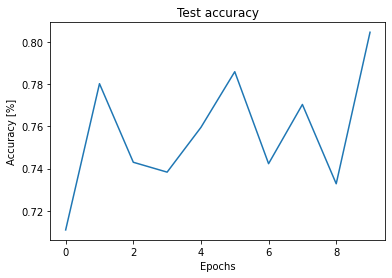

In [5]:
def display_loss_plot(losses, title="Training loss", xlabel="Epochs", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

display_loss_plot(history['val_accuracy'], title="Test accuracy", ylabel="Accuracy [%]")